In [1]:
#base library
import os
import pandas as pd
import numpy as np
import sklearn
import gc
import pickle
import xgboost

#visualization
import seaborn as sns
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
import matplotlib.pyplot as plt


#datacleaning
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#preprocessing
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler,PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

#models
from sklearn.model_selection import GridSearchCV,cross_validate,ParameterGrid,train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC,SVC
from xgboost import XGBClassifier 
# from lightgbm import LGBMClassifier

#model evaluation
from sklearn.metrics import classification_report

#Version control
# import mlflow

In [20]:
CONFIG = dict(
    random_seed = 42,
    train_filepath = os.path.join(r"C:\Users\Acer\OneDrive - DigiPen Institute of Technology\Digipen mowei\Introduction to algorithm\week24" ,"Train.csv"),
    test_filepath  = os.path.join(r"C:\Users\Acer\OneDrive - DigiPen Institute of Technology\Digipen mowei\Introduction to algorithm\week24" ,"Test.csv"),
  
    normalizers = {
        "clf__num__normalizer":[MinMaxScaler(),StandardScaler()]
    },
    
    models = [dict(estimator=RandomForestClassifier(random_state=42),
                   name = "RandomForest",
                   params={"clf__n_estimators":[70,75,85]}),
              
#              dict(estimator=SVC(),
#                   name = "SVC",
#                   params={"C":[0.7,0.8,0.9],
#                           "kernel":['poly','rbf']}),
              
#              dict(estimator=XGBClassifier(use_label_encoder=False),
#                   name = "XGBClassifier",
#                   params={"n_estimators":[90,100,110],
#                           "max_depth":[3,4,5],
#                           "eval_metric":['mlogloss'],
#                           }),
             ],
    
    scorings = ["f1","accuracy","f1_micro",
                "f1_macro","f1_weighted", "roc_auc",
                "precision","recall"],
    
    trained_model_dir = os.path.join("..", "models","trained_model.pkl"),
    
)

In [3]:
train = pd.read_csv(CONFIG['train_filepath'], index_col=0)
test = pd.read_csv(CONFIG['test_filepath'], index_col=0)

In [4]:
train.info()
print()
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, T1 to T2000
Columns: 168 entries, C1 to STATUS
dtypes: float64(2), object(166)
memory usage: 2.6+ MB

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, T1 to T500
Columns: 167 entries, C1 to C167
dtypes: float64(45), int64(4), object(118)
memory usage: 656.2+ KB


In [5]:
train['STATUS']=train['STATUS'].replace({'PASS':1,'FAIL':0})
newtrain = train
newtrain.head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C159,C160,C161,C162,C163,C164,C165,C166,C167,STATUS
T1,0,6.96,0,99.781,0,8.12,116.087,598.864,0,603.605,...,2195,39.844,4.676,130.961,44.875,0,28.008,0.175,5.399,1
T2,0,7.565,0,99.921,0,8.268,116.76,605.493,0,600.802,...,2195,40.41,4.71,131.901,40.438,0,28.006,0.171,5.401,1
T3,0,11.771,0,99.833,0,8.269,121.81,604.341,0,597.587,...,2195,39.442,4.951,138.66,43,0,28.008,0.17,5.399,1
T4,0,0.62,0,100.481,0,8.281,109.595,597.332,0,602.017,...,2195,40.128,4.611,129.158,42.75,0,28.008,0.17,5.399,1
T5,0,1.043,0,100.018,0,8.214,109.5,600.467,0,602.048,...,2195,39.625,4.763,133.42,43.5,0,28.008,0.17,5.400,1


In [6]:
def transform(X):
    X_copy = X.copy()
    for col in X_copy.columns:
        try:
            X_copy[col] = X_copy[col].astype(np.float64)
        except:
            X_copy[col] = pd.to_numeric(X_copy[col],errors="coerce").values
    return X_copy

newtrain = transform(newtrain)
newtest = transform(test)
newtrain.info()
print()
newtest.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, T1 to T2000
Columns: 168 entries, C1 to STATUS
dtypes: float64(168)
memory usage: 2.6+ MB

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, T1 to T500
Columns: 167 entries, C1 to C167
dtypes: float64(167)
memory usage: 656.2+ KB


In [7]:
newtrain.describe()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C159,C160,C161,C162,C163,C164,C165,C166,C167,STATUS
count,1939.0,1999.000000,1939.000000,1999.000000,1939.000000,1999.000000,1999.000000,1999.000000,1939.000000,1999.000000,...,1996.0,1996.000000,1996.000000,1996.000000,1996.000000,1939.0,2000.000000,1999.000000,2000.000000,2000.000000
mean,0.0,4.625774,285.301702,99.991283,385.820010,8.245962,113.613430,600.672489,172.540485,601.128489,...,2195.0,39.871757,4.801253,134.474274,42.812441,0.0,28.007217,0.168245,5.400048,0.950000
std,0.0,3.570945,510.979097,0.396746,691.222764,0.110172,3.856226,3.454111,309.101385,2.181308,...,0.0,0.557178,0.173045,4.846401,1.133115,0.0,0.001360,0.003691,0.000985,0.217999
min,0.0,0.006000,0.000000,98.967000,0.000000,7.560000,107.534000,590.912000,0.000000,594.570000,...,2195.0,37.967000,4.313000,120.814000,37.125000,0.0,28.005000,0.129000,5.399000,0.000000
25%,0.0,0.958500,0.000000,99.639000,0.000000,8.232000,109.747000,598.223000,0.000000,598.547500,...,2195.0,39.511750,4.680000,131.085500,42.063000,0.0,28.006000,0.167000,5.399000,1.000000
50%,0.0,4.861000,0.000000,99.981000,0.000000,8.265000,113.967000,599.780000,0.000000,601.902000,...,2195.0,39.840500,4.777000,133.801500,42.750000,0.0,28.007000,0.169000,5.400000,1.000000
75%,0.0,7.369000,0.000000,100.345500,0.000000,8.296000,116.482000,604.016000,0.000000,602.847500,...,2195.0,40.191500,4.899000,137.217250,43.500000,0.0,28.008000,0.171000,5.401000,1.000000
max,0.0,15.007000,1200.000000,100.781000,1707.000000,8.433000,126.203000,607.500000,786.000000,604.458000,...,2195.0,41.974000,5.409000,151.496000,48.000000,0.0,28.011000,0.182000,5.403000,1.000000


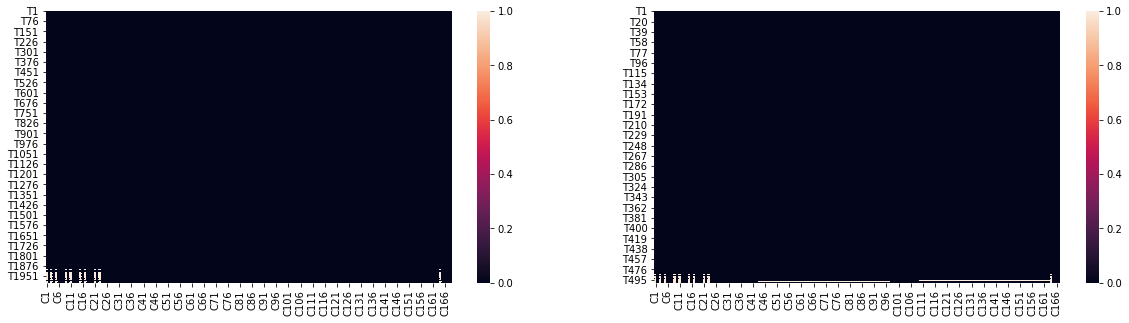

In [8]:
#Checking of missing data heat map
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

sns.heatmap(newtrain.isna(),ax=ax[0])
sns.heatmap(newtest.isna(),ax=ax[1])

plt.show()

In [9]:
for col in newtrain.columns:         # imputation with either mean or mode depending on number of unique entries in each column
    mode = newtrain[col].mode()
    mean = newtrain[col].mean()
    if len(newtrain[col].value_counts()) < 3:
        newtrain[col].fillna(mode[0],inplace=True)
    else:
        newtrain[col].fillna(mean,inplace=True)

In [10]:
newtrain.isnull().sum()

C1        0
C2        0
C3        0
C4        0
C5        0
         ..
C164      0
C165      0
C166      0
C167      0
STATUS    0
Length: 168, dtype: int64

In [11]:
drops = []
for col in newtrain.columns:
    if len(newtrain[col].unique()) == 1:
        drops.append(col)
newtrain.drop(columns=drops, inplace=True)

In [12]:
newtraincorr = abs(newtrain.corr())
newtraincorr = newtraincorr.sort_values(by=['STATUS'], ascending=False)
newtraincorr

,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,...,C157,C158,C160,C161,C162,C163,C165,C166,C167,STATUS
STATUS,0.151533,0.086885,0.093150,0.157214,0.079569,0.151708,0.002680,0.162475,0.007769,0.163740,...,0.079403,0.006902,0.021172,0.009096,0.009032,0.017805,0.046073,0.004519,0.060908,1.000000
C53,0.456187,0.330415,0.286337,0.373398,0.093891,0.454197,0.027944,0.372435,0.017924,0.371615,...,0.146966,0.099986,0.176482,0.098809,0.098799,0.112425,0.026264,0.020868,0.183580,0.508576
C71,0.441112,0.376939,0.275993,0.418092,0.123436,0.439515,0.019691,0.417499,0.016033,0.416524,...,0.150709,0.152216,0.155296,0.152603,0.152561,0.128604,0.048902,0.021359,0.279963,0.498300
C54,0.508522,0.376645,0.318782,0.418985,0.086123,0.506286,0.033892,0.417737,0.019863,0.417019,...,0.158635,0.122675,0.196943,0.121800,0.121818,0.130716,0.007884,0.038811,0.187281,0.493076
C72,0.486540,0.407493,0.305902,0.448748,0.107922,0.484415,0.026058,0.447587,0.018002,0.446861,...,0.163073,0.162594,0.178934,0.162389,0.162347,0.147505,0.050322,0.008683,0.293179,0.490606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C79,0.346474,0.292766,0.195288,0.294990,0.061126,0.346536,0.016235,0.292904,0.019746,0.294457,...,0.095918,0.199349,0.180927,0.199560,0.199584,0.753096,0.008596,0.059971,0.175777,0.002671
C130,0.042363,0.052097,0.003906,0.051598,0.027230,0.043838,0.017657,0.051106,0.017830,0.051367,...,0.027745,0.024231,0.001646,0.024828,0.024842,0.023234,0.034508,0.046375,0.039829,0.001102
C42,0.033885,0.154854,0.010151,0.162103,0.100210,0.031127,0.014909,0.156951,0.001122,0.162762,...,0.020698,0.155508,0.014927,0.148482,0.148729,0.003764,0.080808,0.891655,0.275290,0.000342
C136,0.288750,0.261852,0.164647,0.263628,0.054213,0.288575,0.014220,0.261158,0.002783,0.262990,...,0.077561,0.065502,0.261319,0.066891,0.066993,0.941669,0.036357,0.056089,0.117539,0.000123


In [13]:
#split training data into features and labels
X_train = newtrain.drop("STATUS",axis=1)
y_train = newtrain["STATUS"]

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.1,random_state=CONFIG["random_seed"],stratify=y_train)

In [23]:
trained_models = []
normalizers = CONFIG['normalizers']

for model in CONFIG["models"]:
    model_obj = model["estimator"]
    model_name = model['name']
    model_params = model["params"]

#     numeric_transformer = Pipeline(steps=[
# #             ("feature_selector", VarianceThreshold()),
#             ("normalizer",StandardScaler()),
#             ("imputer",SimpleImputer(strategy='mean')),
#         ])

#     categorical_transformer = Pipeline(steps=[
# #         ("feature_selector", VarianceThreshold()),
#         ("imputer",SimpleImputer(strategy='most_frequent')),
#         ("Ordinal_encoder", OrdinalEncoder())
#     ])

#     preprocessor = ColumnTransformer(transformers=[
#         ('num', numeric_transformer, CONFIG['numerical_cols']),
#         ('cat', categorical_transformer, CONFIG['categorical_cols'])
#     ])

#     preprocessor= Pipeline(steps=[
# #             ("feature_selector", VarianceThreshold()),
#             ("normalizer",StandardScaler()),
#             ("imputer",SimpleImputer(strategy='mean')),
#         ])

    model_pipeline = Pipeline(steps=[
#         ('preprocessing', StandardScaler()),
        ('clf', model_obj),
    ])

    param_grid = {**model_params }

    
    print("Running model:",model_obj, "Model name:",model_name)
    print("model_params:", param_grid)
    
    search_model = GridSearchCV(model_pipeline,param_grid=param_grid,cv=5,scoring=CONFIG['scorings'],refit="f1_macro")
    search_model.fit(X_train,y_train)
    trained_models.append(search_model)

Running model: RandomForestClassifier(random_state=42) Model name: RandomForest
model_params: {'clf__n_estimators': [70, 75, 85]}


In [22]:
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [ ]:
{**normalizers, **model_params }

In [ ]:
RandomForestClassifier(random_state=42).get_params().keys()

In [ ]:
clf=RandomForestClassifier()
pca = PCA()
pca_clf = Pipeline([('pca', pca), ('clf', clf)]) 


kfold = KFold(n_splits=10, shuffle=True, random_state=22)



parameters = {'clf__n_estimators': [4, 6, 9], 'clf__max_features': ['log2', 
'sqrt','auto'],'clf__criterion': ['entropy', 'gini'], 'clf__max_depth': [2, 
 3, 5, 10], 'clf__min_samples_split': [2, 3, 5],
'clf__min_samples_leaf': [1,5,8] }

grid_RF=GridSearchCV(pca_clf,param_grid=parameters,
       scoring=CONFIG['scorings'],refit="f1_macro",cv=kfold)
grid_RF = grid_RF.fit(X_train, y_train)
clf = grid_RF.best_estimator_
clf.fit(X_train, y_train)
grid_RF.best_score_
trained_models.append(clf)


In [ ]:
grid_RF.best_score_

In [ ]:
grid_RF.best_estimator_

In [ ]:
with open(CONFIG["trained_model_dir"] , 'wb') as handles:
    pickle.dump(trained_models, handles, protocol = pickle.HIGHEST_PROTOCOL)
    
with open(CONFIG["trained_model_dir"] , 'rb') as handles:
    trained_models = pickle.load(handles)
    
best_model = get_best_model(trained_models)

In [ ]:
preds = best_model.predict(X_val)
print(classification_report(y_val, preds))

In [ ]:
fig = plt.figure(figsize=(20,30))
ax = plt.gca()
xgboost_model = best_model.best_estimator_['clf']
xgboost_model
xgboost.plot_importance(xgboost_model, ax=ax);

# lgbm_model = best_model.best_estimator_['clf']
# lightgbm.plot_importance(lgbm_model,figsize=(20,30));

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y = X_train['C94'], x= X_train['C30'],mode='markers',marker=dict(color=y_train)))
fig.update_layout(title="Top 2 feature against label",xaxis=dict(title='C30'),yaxis=dict(title='C94'))
fig.show()

In [ ]:
print(__doc__)

# Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data[:, 0:2]  # we only take the first two features for visualization
y = iris.target

n_features = X.shape[1]

C = 10
kernel = 1.0 * RBF([1.0, 1.0])  # for GPC

# Create different classifiers.
classifiers = {
    'L1 logistic': LogisticRegression(C=C, penalty='l1',
                                      solver='saga',
                                      multi_class='multinomial',
                                      max_iter=10000),
    'L2 logistic (Multinomial)': LogisticRegression(C=C, penalty='l2',
                                                    solver='saga',
                                                    multi_class='multinomial',
                                                    max_iter=10000),
    'L2 logistic (OvR)': LogisticRegression(C=C, penalty='l2',
                                            solver='saga',
                                            multi_class='ovr',
                                            max_iter=10000),
    'Linear SVC': SVC(kernel='linear', C=C, probability=True,
                      random_state=0),
    'GPC': GaussianProcessClassifier(kernel)
}

n_classifiers = len(classifiers)

plt.figure(figsize=(3 * 2, n_classifiers * 2))
plt.subplots_adjust(bottom=.2, top=.95)

xx = np.linspace(3, 9, 100)
yy = np.linspace(1, 5, 100).T
xx, yy = np.meshgrid(xx, yy)
Xfull = np.c_[xx.ravel(), yy.ravel()]

for index, (name, classifier) in enumerate(classifiers.items()):
    classifier.fit(X, y)

    y_pred = classifier.predict(X)
    accuracy = accuracy_score(y, y_pred)
    print("Accuracy (train) for %s: %0.1f%% " % (name, accuracy * 100))

    # View probabilities:
    probas = classifier.predict_proba(Xfull)
    n_classes = np.unique(y_pred).size
    for k in range(n_classes):
        plt.subplot(n_classifiers, n_classes, index * n_classes + k + 1)
        plt.title("Class %d" % k)
        if k == 0:
            plt.ylabel(name)
        imshow_handle = plt.imshow(probas[:, k].reshape((100, 100)),
                                   extent=(3, 9, 1, 5), origin='lower')
        plt.xticks(())
        plt.yticks(())
        idx = (y_pred == k)
        if idx.any():
            plt.scatter(X[idx, 0], X[idx, 1], marker='o', c='w', edgecolor='k')

ax = plt.axes([0.15, 0.04, 0.7, 0.05])
plt.title("Probability")
plt.colorbar(imshow_handle, cax=ax, orientation='horizontal')

plt.show()